Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./SkinCancerImages/Train")
data_dir_test = pathlib.Path('./SkinCancerImages/Test')

In [4]:
import shutil

# If re-running the cells, better to delete older files if any
for root, dirs, files in os.walk(data_dir_train):
    if 'output' in dirs:
        output_dir = os.path.join(root, 'output')
        # Delete the 'output' directory if it exists
        if os.path.exists(output_dir):
            shutil.rmtree(output_dir)
            print(f"Deleted: {output_dir}")

Deleted: SkinCancerImages/Train/melanoma/output
Deleted: SkinCancerImages/Train/pigmented benign keratosis/output
Deleted: SkinCancerImages/Train/nevus/output
Deleted: SkinCancerImages/Train/basal cell carcinoma/output
Deleted: SkinCancerImages/Train/actinic keratosis/output
Deleted: SkinCancerImages/Train/squamous cell carcinoma/output
Deleted: SkinCancerImages/Train/vascular lesion/output
Deleted: SkinCancerImages/Train/seborrheic keratosis/output
Deleted: SkinCancerImages/Train/dermatofibroma/output


In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f'Training Images: {image_count_train}')
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f'Test Images    : {image_count_test}')

Training Images: 2239
Test Images    : 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

validation_split = 0.2 # 20% for validation

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                data_dir_train,
                validation_split=validation_split,
                subset='training',
                seed=123,
                image_size=(img_height, img_width),
                batch_size=batch_size,
                label_mode='categorical') # does one-hot encoding of categories

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
# Display a sample output
for images, labels in train_ds.take(1):
    print(images.shape, labels.shape)

(32, 180, 180, 3) (32, 9)


2024-12-17 19:12:10.922975: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                data_dir_train,
                validation_split=validation_split,
                subset='validation',
                seed=123,
                image_size=(img_height, img_width),
                batch_size=batch_size,
                label_mode='categorical')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# Display a sample output
for images, labels in val_ds.take(1):
    print(images.shape, labels.shape)

(32, 180, 180, 3) (32, 9)


2024-12-17 19:12:11.046301: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [12]:
# dict to store one sample per class
samples_per_class = {class_name: None for class_name in class_names}

# collect one sample per class
for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_name = class_names[tf.argmax(label).numpy()]
        if samples_per_class[class_name] is None:
            samples_per_class[class_name] = img

        # stop when all classes are there
        if all(val is not None for val in samples_per_class.values()):
            break;
            
    if all(val is not None for val in samples_per_class.values()):
        break;

print(samples_per_class.keys())

dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])


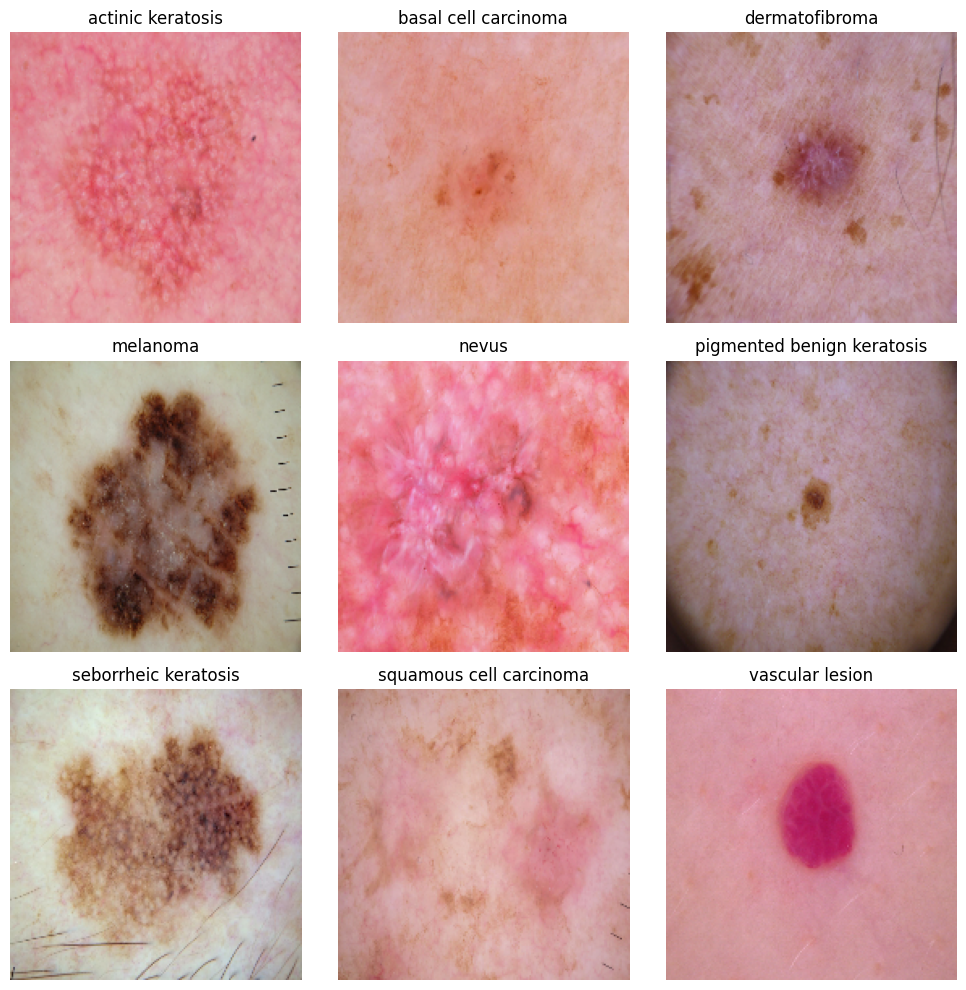

In [13]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10,10))
for i, (class_name, img) in enumerate(samples_per_class.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(img.numpy().astype('uint8'))
    plt.title(class_name)
    plt.axis('off')

plt.tight_layout()
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### Your code goes here
def create_model(input_shape=(img_height, img_width, 3), num_classes=9):
    model = Sequential([
        # input rescaling layer: Normalize pizels to [0, 1]
        layers.Rescaling(1.0/255, input_shape=input_shape),
        
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Flattening layer
        layers.Flatten(),

        # Fully Connected Layers
        layers.Dense(256, activation='relu'),

        # Ouptut Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [16]:
# create the model
input_shape = (img_height, img_width, 3)
num_classes = len(class_names)

model_1 = create_model(input_shape, num_classes)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [17]:
### Todo, choose an appropirate optimiser and loss function
model_1.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [18]:
# View the summary of all layers
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 43, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    14,450,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,546,505 (55.49 MB)

 Trainable params: 14,546,505 (55.49 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [19]:
epochs = 20
history_1 = model_1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.1763 - auc: 0.6326 - loss: 2.3074 - val_accuracy: 0.3647 - val_auc: 0.7837 - val_loss: 1.7828
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.4024 - auc: 0.8077 - loss: 1.6767 - val_accuracy: 0.4720 - val_auc: 0.8348 - val_loss: 1.6015
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.4729 - auc: 0.8538 - loss: 1.4935 - val_accuracy: 0.5302 - val_auc: 0.8715 - val_loss: 1.3915
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.5234 - auc: 0.8825 - loss: 1.3391 - val_accuracy: 0.5056 - val_auc: 0.8607 - val_loss: 1.5121
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.5234 - auc: 0.8804 - loss: 1.3579 - val_accuracy: 0.4989 - val_auc: 0.8657 - val_loss: 1.4528
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.5646 - auc: 0.8979 - loss: 1.2591 - val_accuracy: 0.5436 - val_auc: 0.8877 - val_loss: 1.3511
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━

### Visualizing training results

In [20]:
def visualize_results(history, epochs=20):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    
    epochs_range = range(epochs)
    
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, auc, label='Training AUC')
    plt.plot(epochs_range, val_auc, label='Validation AUC')
    plt.legend(loc='upper right')
    plt.title('Training and Validation AUC')
    plt.show()

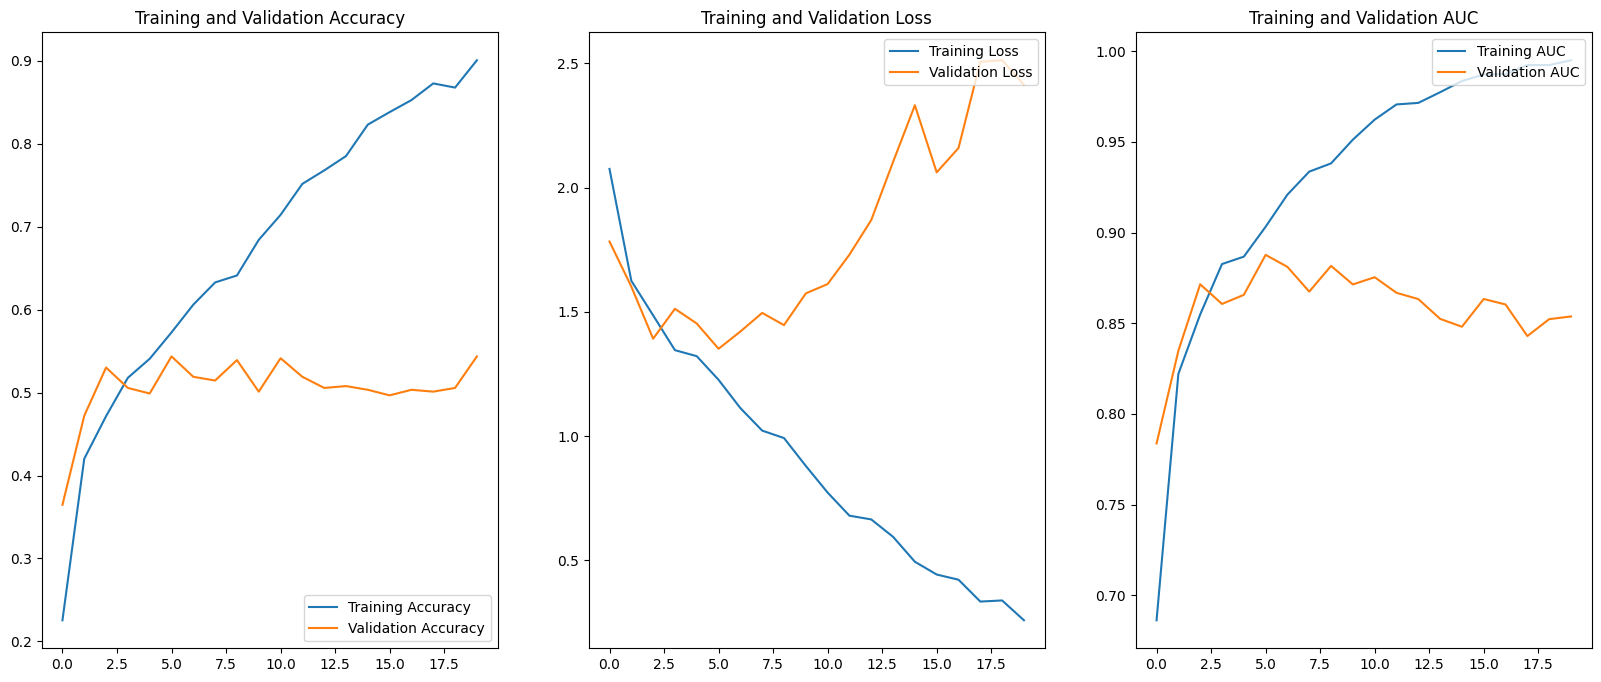

In [21]:
visualize_results(history_1, epochs)

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

In [23]:
def get_confusion_classification_report(model, val_ds):
    # Get true labels and predictions for the validation set
    y_true = np.concatenate([y for x, y in val_ds], axis=0)
    y_pred = model.predict(val_ds)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Calculate classification report
    class_report = classification_report(y_true_classes, y_pred_classes)
    
    print("\nClassification Report:")
    print(class_report)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


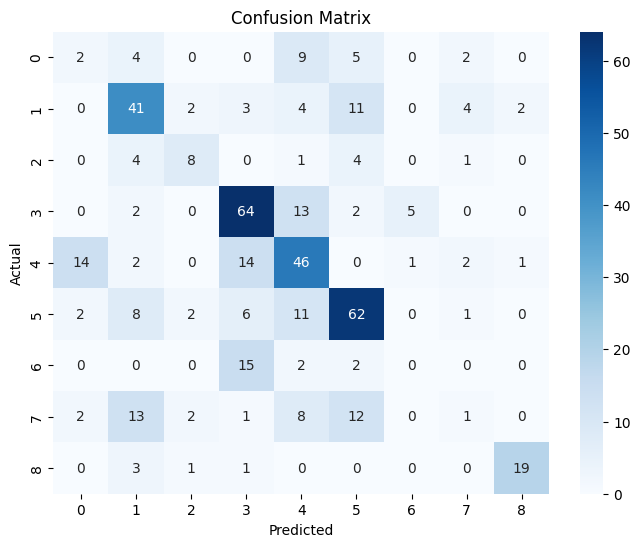


Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.09      0.10        22
           1       0.53      0.61      0.57        67
           2       0.53      0.44      0.48        18
           3       0.62      0.74      0.67        86
           4       0.49      0.57      0.53        80
           5       0.63      0.67      0.65        92
           6       0.00      0.00      0.00        19
           7       0.09      0.03      0.04        39
           8       0.86      0.79      0.83        24

    accuracy                           0.54       447
   macro avg       0.43      0.44      0.43       447
weighted avg       0.50      0.54      0.52       447



In [24]:
get_confusion_classification_report(model_1, val_ds)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

### Observations - Findings
- **Training Performance**: The model's training accuracy and AUC are consistently improving, and the loss is decreasing, indicating that the model is learning well on the training data.
- **Validation Performance**: The validation accuracy and AUC are much lower and the loss is higher compared to the training metrics. This suggests that the model might be **overfitting**, meaning it performs well on the training data but not as well on the validation data.

Further, from <u>confusion matrix</u> and <u>classification report</u>, it seems its **Overfitting to specific classes** 
- **Class Imbalance**: Some classes (e.g., class 6) have very low precision and recall, indicating that the model struggles with these classes. This could be due to **class imbalance**.
- **Overall Performance**: The overall accuracy is 45%, which aligns with the validation accuracy observed during training. The model performs well on some classes (e.g., class 8) but poorly on others (e.g., class 6).

**Next Steps**: Consider techniques to reduce overfitting, such dropouts

In [25]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = tf.keras.Sequential([
    # randomly flip horizontal and vertical
    layers.RandomFlip('horizontal_and_vertical', input_shape=(img_height, img_width, 3)),

    # randomly rotate the image
    layers.RandomRotation(0.1),

    # randomly zoom in/out
    layers.RandomZoom(0.1),

    # randoml adjust brightness
    layers.RandomBrightness(0.1),

    # randomly adjust contrast
    layers.RandomContrast(0.1)
])

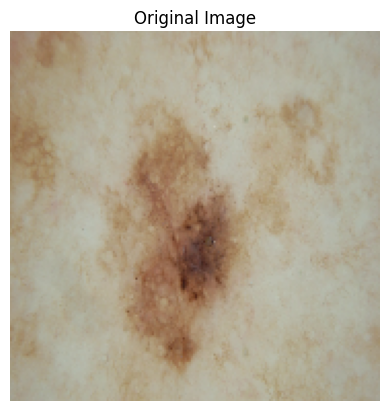

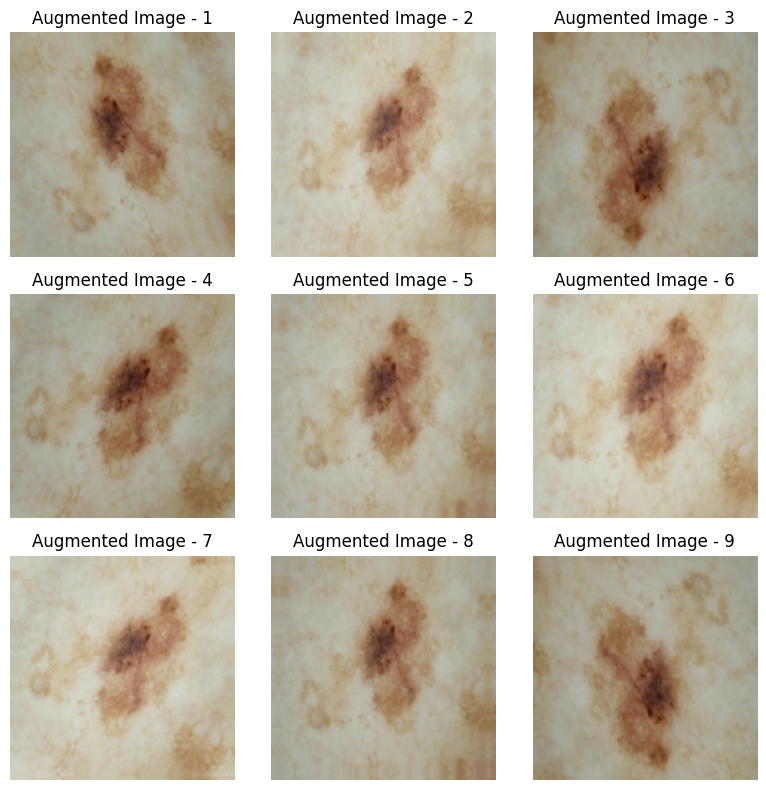

In [26]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# load one batch from the trainging_ds
for images, labels in train_ds.take(1):
    sample_image = images[0]
    break;

# apply augmentation multiple times to visualize effects
num_augmentation = 9 # num of images to display
augmented_images = [data_augmentation(tf.expand_dims(sample_image, 0), training=True)[0] for i in range(num_augmentation)]

# plot it
plt.imshow(sample_image.numpy().astype('uint8'))
plt.title('Original Image')
plt.axis('off')
plt.show()

# show augmented images
plt.figure(figsize=(8, 8))
for i, aug_img in enumerate(augmented_images, start=1):
    plt.subplot(3, 3, i)
    plt.imshow(aug_img.numpy().astype('uint8'))
    plt.title(f'Augmented Image - {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Todo:
### Create the model, compile and train the model


In [27]:
from tensorflow.keras.optimizers import Adam

In [28]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

def create_model_augmented(input_shape=(img_height, img_width, 3), num_classes=9):
    model = Sequential([

        # data augmentation
        data_augmentation,
        
        # input rescaling layer: Normalize pizels to [0, 1]
        layers.Rescaling(1.0/255, input_shape=input_shape),
        
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2), # adding a dropout

        # Flattening layer
        layers.Flatten(),

        # Fully Connected Layers
        layers.Dense(256, activation='relu'),

        # Ouptut Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [29]:
model_2_augmented = create_model_augmented(input_shape, num_classes)

### Compiling the model

In [30]:
## Your code goes here
### Todo, choose an appropirate optimiser and loss function
model_2_augmented.compile(optimizer='adam',
                          loss='categorical_crossentropy',
                          metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [31]:
model_2_augmented.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 43, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    14,450,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,546,505 (55.49 MB)

 Trainable params: 14,546,505 (55.49 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [32]:
## Your code goes here, note: train your model for 20 epochs
history_2_augmented = model_2_augmented.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    # callbacks=[lr_callback]
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 215ms/step - accuracy: 0.2307 - auc: 0.6548 - loss: 2.4831 - val_accuracy: 0.3893 - val_auc: 0.8172 - val_loss: 1.6434
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.4135 - auc: 0.8264 - loss: 1.6028 - val_accuracy: 0.4586 - val_auc: 0.8466 - val_loss: 1.5209
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.4667 - auc: 0.8440 - loss: 1.5315 - val_accuracy: 0.5078 - val_auc: 0.8622 - val_loss: 1.4636
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - accuracy: 0.5154 - auc: 0.8673 - loss: 1.4261 - val_accuracy: 0.5235 - val_auc: 0.8749 - val_loss: 1.3877
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 217ms/step - accuracy: 0.4980 - auc: 0.8739 - loss: 1.3894 - val_accuracy: 0.4810 - val_auc: 0.8638 - val_loss: 1.4526
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 214ms/step - accuracy: 0.4965 - auc: 0.8749 - loss: 1.3912 - val_accuracy: 0.4765 - val_auc: 0.8596 - val_loss: 1.6173
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━

### Visualizing the results

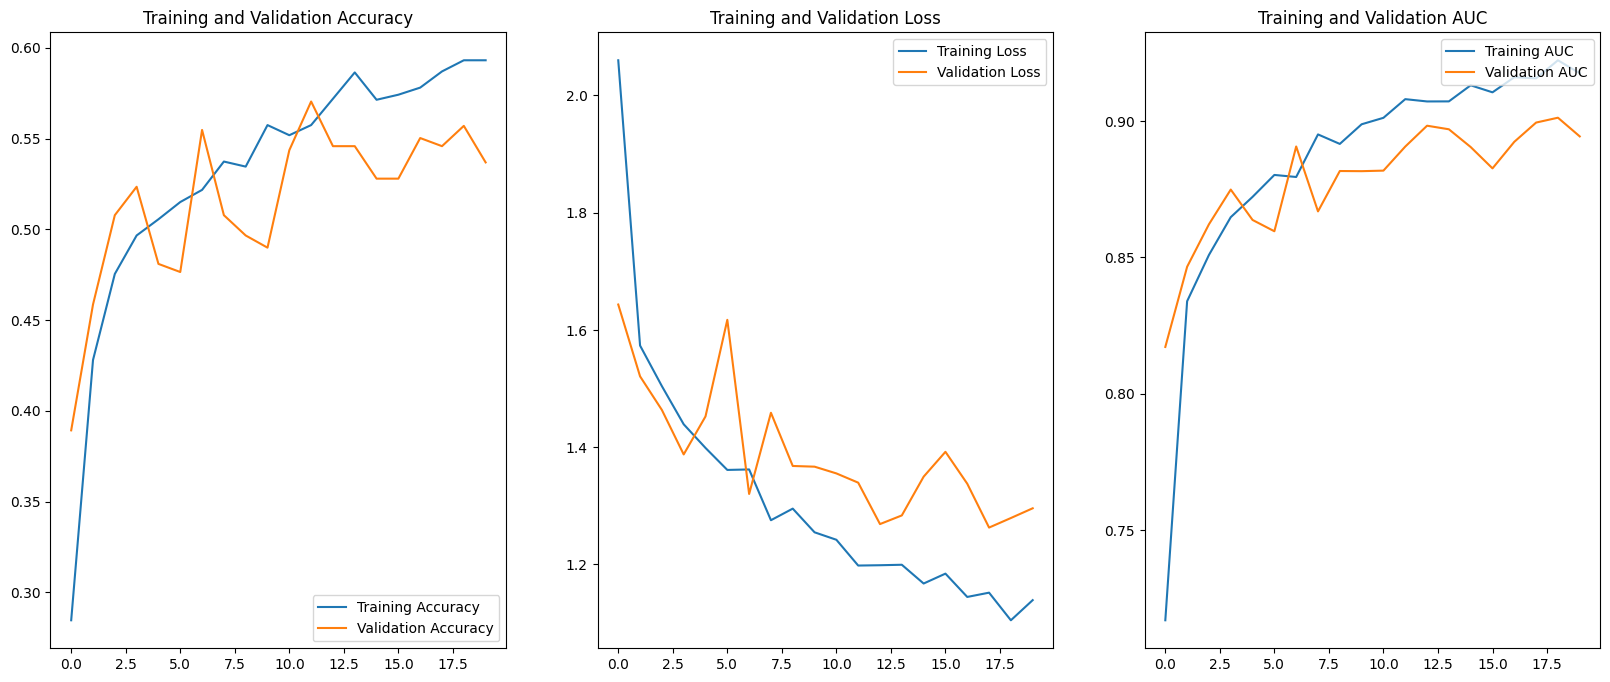

In [33]:
visualize_results(history_2_augmented)

 3/14 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

2024-12-17 19:19:59.405520: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


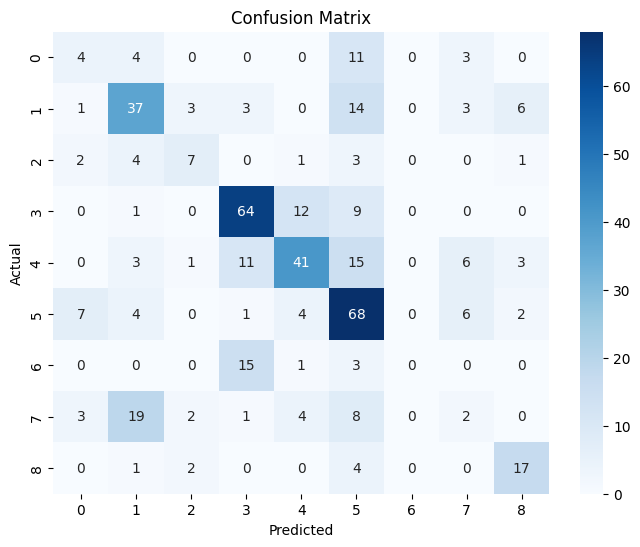


Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.18      0.21        22
           1       0.51      0.55      0.53        67
           2       0.47      0.39      0.42        18
           3       0.67      0.74      0.71        86
           4       0.65      0.51      0.57        80
           5       0.50      0.74      0.60        92
           6       0.00      0.00      0.00        19
           7       0.10      0.05      0.07        39
           8       0.59      0.71      0.64        24

    accuracy                           0.54       447
   macro avg       0.41      0.43      0.42       447
weighted avg       0.50      0.54      0.51       447



In [34]:
get_confusion_classification_report(model_2_augmented, val_ds)

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Observations**

- **Training Performance**: The model's training accuracy and AUC are gradually improving, and the loss is decreasing, indicating that the model is learning from the training data.
- **Validation Performance**: The validation accuracy and AUC are lower compared to the training metrics, and the validation loss is higher

The gap between the training and validation loss has narrowed, indicating that the <u>overfitting issue has been mitigated</u> due to Dropouts and data augmentation

- **Class Imbalance**: Some classes (e.g., class 6) have very low precision and recall, indicating that the model struggles with these classes. This could be due to class imbalance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

### Checking for class imblance

plotting each class

In [35]:
from glob import glob

def class_counter(data_dir):
    class_counts = {}
    class_folders = glob(os.path.join(data_dir, '*'))
    for class_folder in class_folders:
        class_name = os.path.basename(class_folder)
        num_images = len(glob(os.path.join(class_folder, '*.jpg')))
        class_counts[class_name] = num_images
    return class_counts

In [36]:
# Get class distributions
train_class_count = class_counter(data_dir_train)
test_class_count = class_counter(data_dir_test)
train_class_count, test_class_count

({'melanoma': 438,
  'pigmented benign keratosis': 462,
  'nevus': 357,
  'basal cell carcinoma': 376,
  'actinic keratosis': 114,
  'squamous cell carcinoma': 181,
  'vascular lesion': 139,
  'seborrheic keratosis': 77,
  'dermatofibroma': 95},
 {'melanoma': 16,
  'pigmented benign keratosis': 16,
  'nevus': 16,
  'basal cell carcinoma': 16,
  'actinic keratosis': 16,
  'squamous cell carcinoma': 16,
  'vascular lesion': 3,
  'seborrheic keratosis': 3,
  'dermatofibroma': 16})

In [37]:
def plot_class_distribution(class_counts, title):
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.bar(classes, counts)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    # plt.show()

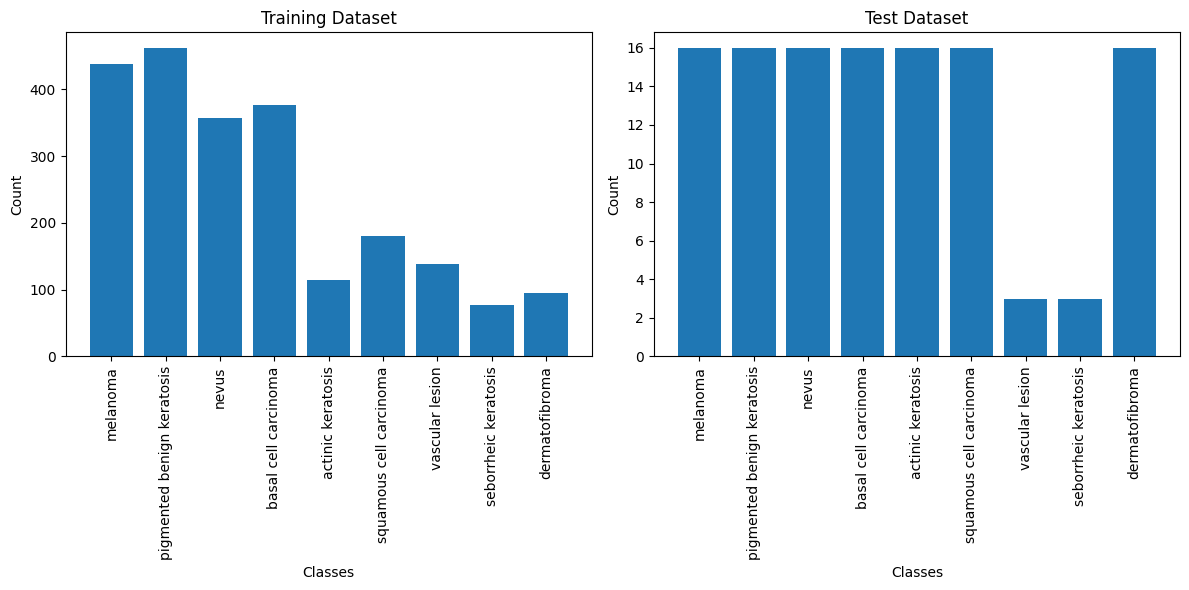

In [38]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_class_distribution(train_class_count, 'Training Dataset')

plt.subplot(1, 2, 2)
plot_class_distribution(test_class_count, 'Test Dataset')

plt.tight_layout()
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


**Observations**

Above graph clearly depicts class imbalance in botht the training and test dataset

- **Least Number of Samples**: in Training set,'seborrheic keratosis' has least number of samples at 77. In test dataset, 'vascular lesion' and seborrheic keratosis' have least number of counts
- **Dominating classes**: 'pigmented benign keratosis' and 'melanoma' classes have the highest samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(data_dir_train, i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to SkinCancerImages/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3278D7380>: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 501.38 Samples/s]


Initialised with 376 image(s) found.
Output directory set to SkinCancerImages/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x327883860>: 100%|████████████████████████████████████████████████████| 500/500 [00:01<00:00, 493.14 Samples/s]


Initialised with 95 image(s) found.
Output directory set to SkinCancerImages/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x327E74500>: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 467.17 Samples/s]


Initialised with 438 image(s) found.
Output directory set to SkinCancerImages/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x3278FB710>: 100%|███████████████████████████████████████████████████| 500/500 [00:04<00:00, 122.17 Samples/s]


Initialised with 357 image(s) found.
Output directory set to SkinCancerImages/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x3D5CF1550>: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 123.10 Samples/s]


Initialised with 462 image(s) found.
Output directory set to SkinCancerImages/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x327E416D0>: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 453.12 Samples/s]


Initialised with 77 image(s) found.
Output directory set to SkinCancerImages/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x17FFDC830>: 100%|███████████████████████████████████████████████████| 500/500 [00:02<00:00, 245.31 Samples/s]


Initialised with 181 image(s) found.
Output directory set to SkinCancerImages/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x327A36FF0>: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 462.39 Samples/s]


Initialised with 139 image(s) found.
Output directory set to SkinCancerImages/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3D62EA8A0>: 100%|██████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 483.13 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [40]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [41]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list[0:5]

['SkinCancerImages/Train/melanoma/output/melanoma_original_ISIC_0011169.jpg_32502519-6c3e-449b-94d0-f8152cecbcce.jpg',
 'SkinCancerImages/Train/melanoma/output/melanoma_original_ISIC_0000547.jpg_79185388-39a7-4da5-8fd5-db9ae3a2c7bb.jpg',
 'SkinCancerImages/Train/melanoma/output/melanoma_original_ISIC_0010289.jpg_91f6244b-c728-41c5-903f-56ad029d91c8.jpg',
 'SkinCancerImages/Train/melanoma/output/melanoma_original_ISIC_0010349.jpg_45c9f910-d40b-4962-9a09-6a242090c649.jpg',
 'SkinCancerImages/Train/melanoma/output/melanoma_original_ISIC_0010796.jpg_ed76e658-00d7-49cc-b8b4-6213fa06f1cc.jpg']

In [42]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[0:5]

['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma']

In [43]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [44]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2.head()

,Path,Label
0,SkinCancerImages/Train/melanoma/output/melanom...,melanoma
1,SkinCancerImages/Train/melanoma/output/melanom...,melanoma
2,SkinCancerImages/Train/melanoma/output/melanom...,melanoma
3,SkinCancerImages/Train/melanoma/output/melanom...,melanoma
4,SkinCancerImages/Train/melanoma/output/melanom...,melanoma


In [45]:
def class_counter_augmented(data_dir):
    class_counts = {}
    class_folders = glob(os.path.join(data_dir, '*'))
    for class_folder in class_folders:
        class_name = os.path.basename(class_folder)
        num_images = len(glob(os.path.join(class_folder, 'output', '*.jpg')))
        class_counts[class_name] = num_images
    return class_counts

In [46]:
# Get class distributions
train_class_aug_count = class_counter_augmented(data_dir_train)
train_class_count, train_class_aug_count

({'melanoma': 438,
  'pigmented benign keratosis': 462,
  'nevus': 357,
  'basal cell carcinoma': 376,
  'actinic keratosis': 114,
  'squamous cell carcinoma': 181,
  'vascular lesion': 139,
  'seborrheic keratosis': 77,
  'dermatofibroma': 95},
 {'melanoma': 500,
  'pigmented benign keratosis': 500,
  'nevus': 500,
  'basal cell carcinoma': 500,
  'actinic keratosis': 500,
  'squamous cell carcinoma': 500,
  'vascular lesion': 500,
  'seborrheic keratosis': 500,
  'dermatofibroma': 500})

In [47]:
combined_dict = {key: train_class_count[key] + train_class_aug_count[key] for key in train_class_count}
combined_dict

{'melanoma': 938,
 'pigmented benign keratosis': 962,
 'nevus': 857,
 'basal cell carcinoma': 876,
 'actinic keratosis': 614,
 'squamous cell carcinoma': 681,
 'vascular lesion': 639,
 'seborrheic keratosis': 577,
 'dermatofibroma': 595}

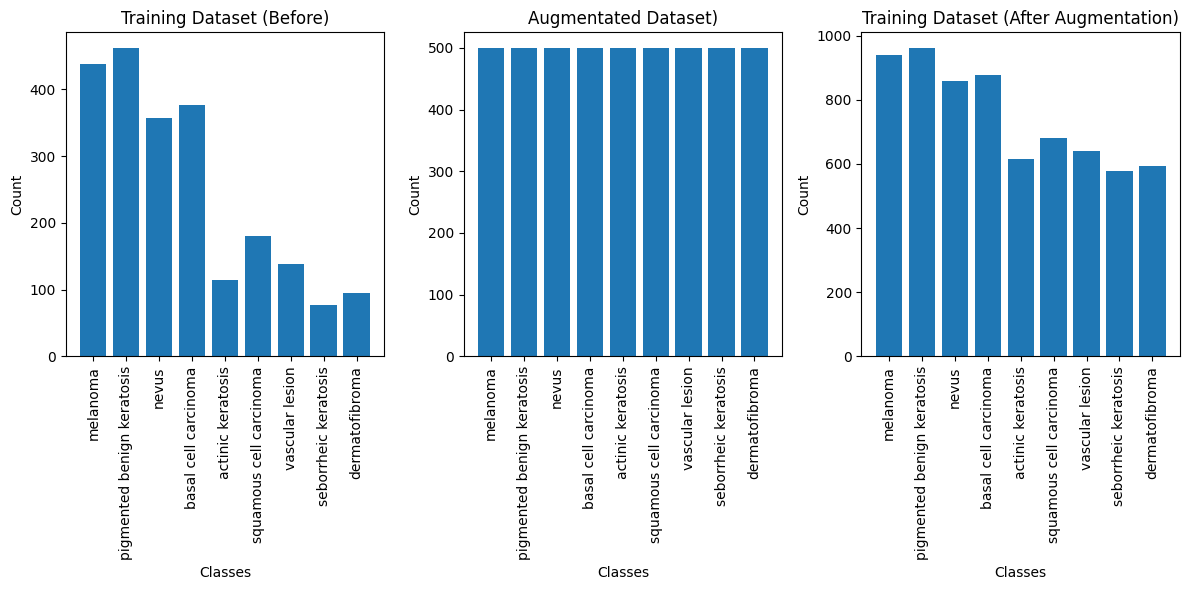

In [48]:
plt.figure(figsize=(12,6))

plt.subplot(1, 3, 1)
plot_class_distribution(train_class_count, 'Training Dataset (Before)')

plt.subplot(1, 3, 2)
plot_class_distribution(train_class_aug_count, 'Augmentated Dataset)')

plt.subplot(1, 3, 3)
plot_class_distribution(combined_dict, 'Training Dataset (After Augmentation)')

plt.tight_layout()
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [49]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [50]:
# data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                data_dir_train,
                validation_split=validation_split,
                subset='training',
                seed=123,
                image_size=(img_height, img_width),
                batch_size=batch_size,
                label_mode='categorical')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [51]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [52]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [53]:
## your code goes here
from tensorflow.keras.regularizers import l2

def create_model_3_augmentor(input_shape=(img_height, img_width, 3), num_classes=9):
    model = Sequential([
        # input rescaling layer: Normalize pizels to [0, 1]
        layers.Rescaling(1.0/255, input_shape=input_shape),
        
        # First Convolutional Block
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2), # adding a dropout

        # Flattening layer
        layers.Flatten(),

        # Fully Connected Layers
        layers.Dense(256, activation='relu'),

        # Ouptut Layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [54]:
model_3_augmentor = create_model_3_augmentor(input_shape, num_classes)

In [55]:
## your code goes here
model_3_augmentor.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

In [56]:
model_3_augmentor.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 43, 43, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 56448)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    14,450,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,546,505 (55.49 MB)

 Trainable params: 14,546,505 (55.49 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [57]:
epochs = 30
## Your code goes here.
history_3_augmentor = model_3_augmentor.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 210ms/step - accuracy: 0.2011 - auc: 0.6270 - loss: 2.2432 - val_accuracy: 0.3601 - val_auc: 0.8348 - val_loss: 1.5590
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.4084 - auc: 0.8526 - loss: 1.4955 - val_accuracy: 0.5271 - val_auc: 0.8974 - val_loss: 1.2709
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.5412 - auc: 0.9039 - loss: 1.2304 - val_accuracy: 0.6036 - val_auc: 0.9246 - val_loss: 1.0961
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.6107 - auc: 0.9273 - loss: 1.0719 - val_accuracy: 0.5828 - val_auc: 0.9209 - val_loss: 1.1255
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 34s 204ms/step - accuracy: 0.6623 - auc: 0.9491 - loss: 0.9011 - val_accuracy: 0.6860 - val_auc: 0.9500 - val_loss: 0.8800
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 35s 208ms/step - accuracy: 0.7234 - auc: 0.9656 - loss: 0.7390 - val_accuracy: 0.6964 - val_auc: 0.9517 - val_loss: 0.8748
Epoch 7/30
169/169 ━━━

#### **Todo:**  Visualize the model results

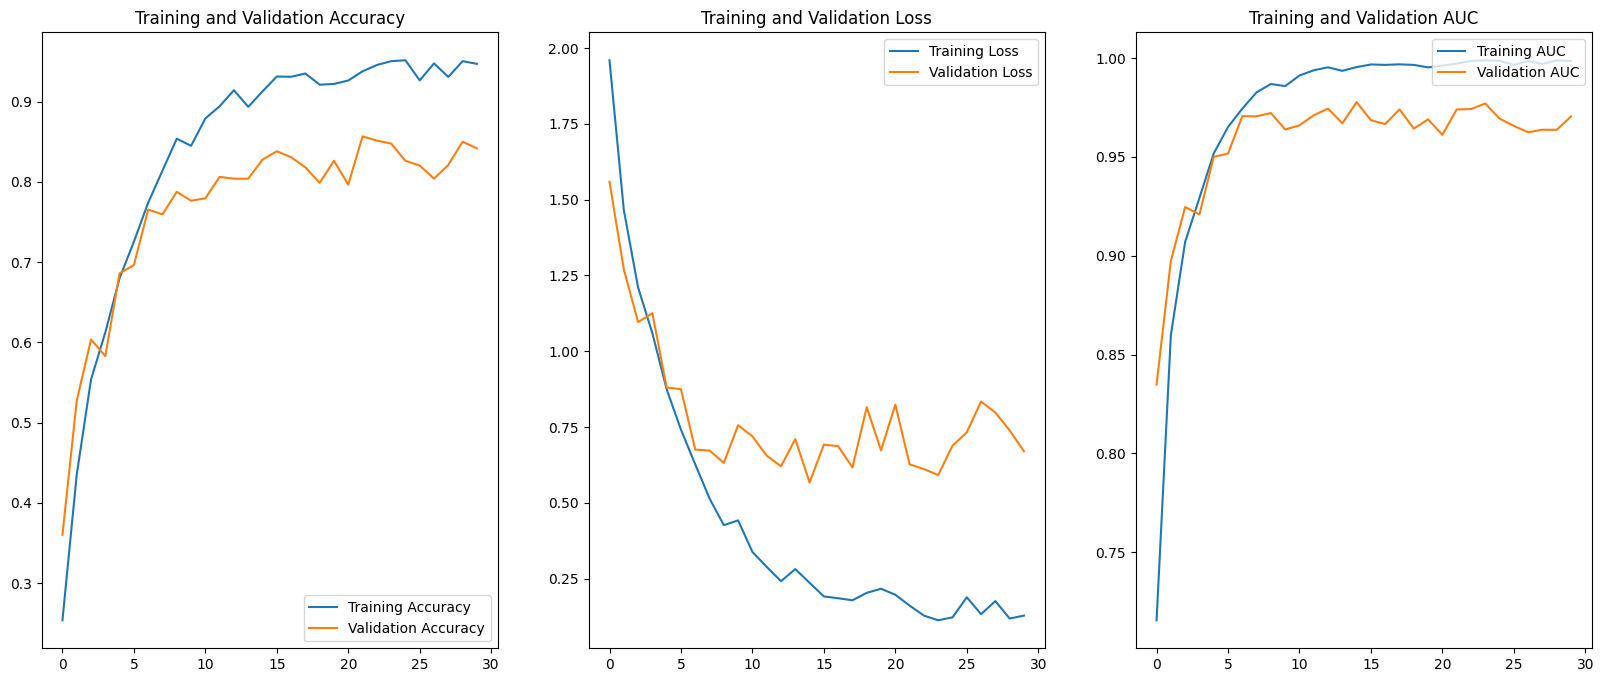

In [58]:
visualize_results(history_3_augmentor, epochs)

43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


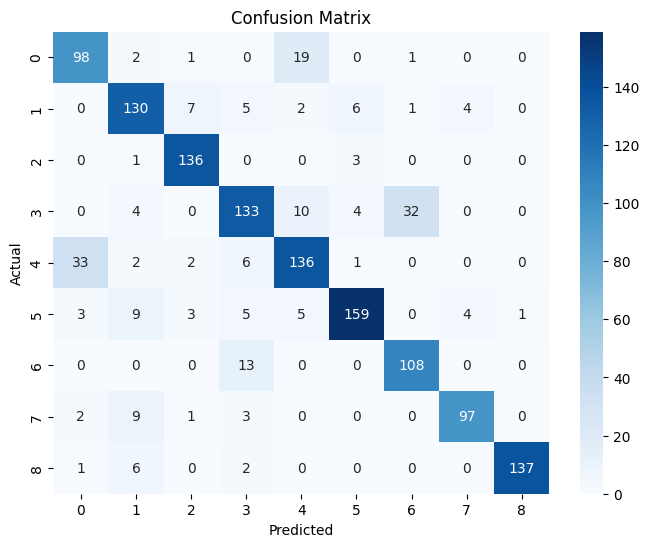


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       121
           1       0.80      0.84      0.82       155
           2       0.91      0.97      0.94       140
           3       0.80      0.73      0.76       183
           4       0.79      0.76      0.77       180
           5       0.92      0.84      0.88       189
           6       0.76      0.89      0.82       121
           7       0.92      0.87      0.89       112
           8       0.99      0.94      0.96       146

    accuracy                           0.84      1347
   macro avg       0.84      0.85      0.85      1347
weighted avg       0.85      0.84      0.84      1347



In [59]:
get_confusion_classification_report(model_3_augmentor, val_ds)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The significant increase in training and validation accuracy is attributed to data augmentation and handling class imbalance. The model is **no longer overfitting** and can be considered as the final model.

- Training Accuracy: 94.5%
- Validation Accuracy: 84%